# Porting

Here we discuss moving an existing workflow from scripts into a notebook

In the `script` directory we have a main script (`script.R`) which runs a simple RNASeq differential-expression
pipeline using the DESeq2 bioconductor package; the examples and routines are from Stephen Turner, who
runs a nice blog called [Getting Genetics Done](http://www.gettinggeneticsdone.com/)

Demo: `Rscript script.R`

Just as in the script, we can source the individual components and get those parts in as long as we get the path right:

In [1]:
source('./script/get_data.R')

In [2]:
ls()

[1] "coldata"   "countdata"

In [3]:
head(countdata)

,SRR493366,SRR493367,SRR493368,SRR493369,SRR493370,SRR493371
ENSG00000186092,0,0,0,0,0,0
ENSG00000279928,0,0,0,0,0,0
ENSG00000279457,23,28,29,29,28,46
ENSG00000278566,0,0,0,0,0,0
ENSG00000273547,0,0,0,0,0,0
ENSG00000187634,124,123,205,207,212,258


Let's try the first few lines in the script.  

For the purposes of a notebook, it's handy to wrap library routines (esp the bioconductor ones!!!) with supressPackageStartupMessages:

In [4]:
suppressPackageStartupMessages(library(DESeq2))

# Create a coldata frame and instantiate the DESeqDataSet. See ?DESeqDataSetFromMatrix
dds <- DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
dds

# Run the DESeq pipeline
dds <- DESeq(dds)

# Plot dispersions
png("qc-dispersions.png", 1000, 1000, pointsize=20)
plotDispEsts(dds, main="Dispersion plot")
dev.off()


class: DESeqDataSet 
dim: 19808 6 
metadata(0):
assays(1): counts
rownames(19808): ENSG00000186092 ENSG00000279928 ... ENSG00000277475
  ENSG00000268674
rowRanges metadata column names(0):
colnames(6): SRR493366 SRR493367 ... SRR493370 SRR493371
colData names(1): condition

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


pdf 
  2

So that's fine as far it goes, but we don't actually want output as file!  We want it inline.  So let's get rid of those `png()`/`dev.off()` wrappers.  

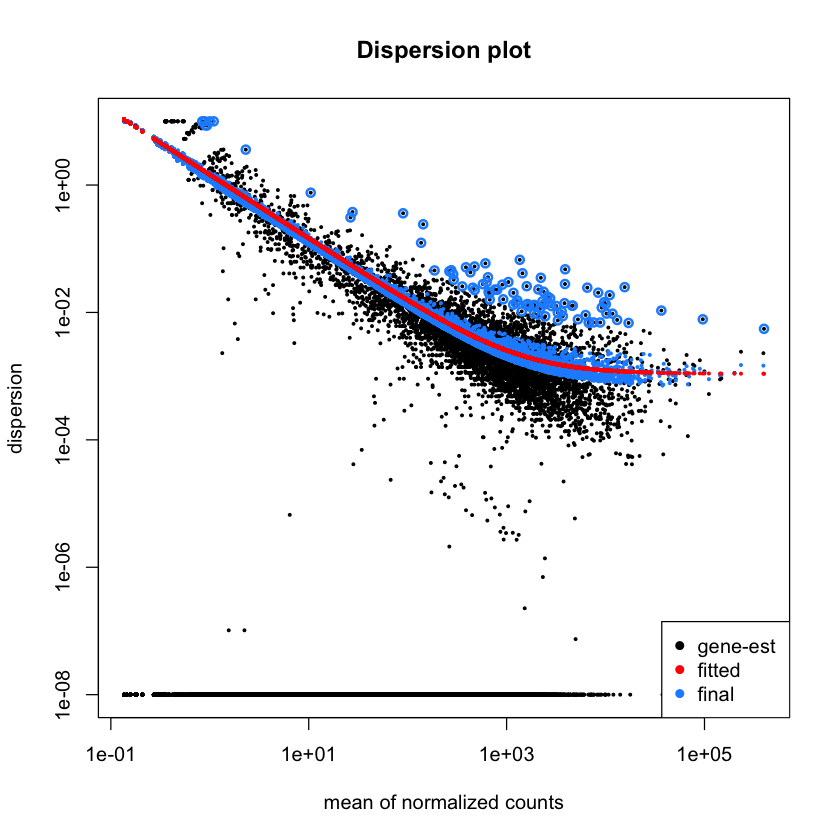

In [5]:
# Plot dispersions
plotDispEsts(dds, main="Dispersion plot")

Ah, that's better - and we can use `options` as before to set the size somewhat better.

Note too that comments are a decent starting point for explanitory text:

## DESeq analysis:

We begin by instantiating the DESeq dataset from the matrix of counts, and then running the pipeline

In [6]:
dds <- DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
# Run the DESeq pipeline
dds <- DESeq(dds)
print(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


class: DESeqDataSet 
dim: 19808 6 
metadata(0):
assays(3): counts mu cooks
rownames(19808): ENSG00000186092 ENSG00000279928 ... ENSG00000277475
  ENSG00000268674
rowRanges metadata column names(27): baseMean baseVar ... deviance
  maxCooks
colnames(6): SRR493366 SRR493367 ... SRR493370 SRR493371
colData names(2): condition sizeFactor


## Quality Control plots:

We start with examining some overall plots of counts to visually examine the data; in the first, we loko at dispersions vs counts, ensuring a reasonable number of outliers:

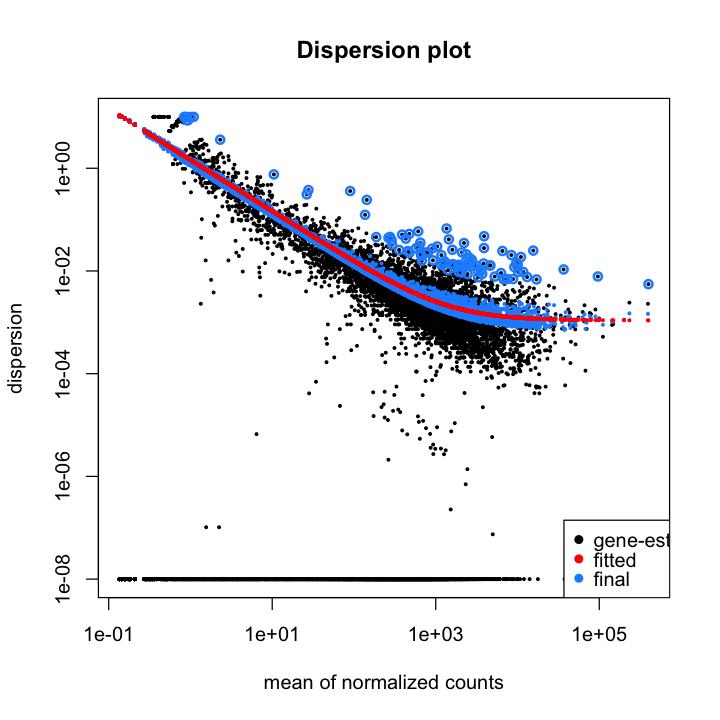

In [7]:
options(repr.plot.height=6, repr.plot.width=6)
plotDispEsts(dds, main="Dispersion plot")

Let's go a little further, skipping ahead to the PCA plots: the script is:
```

rld <- rlogTransformation(dds)
head(assay(rld))
hist(assay(rld))

library(RColorBrewer)
(mycols <- brewer.pal(8, "Dark2")[1:length(unique(coldata$condition))])

# Principal components analysis
# Built-In DESeq2 plot:

png("qc-pca-deseq.png", 1000, 1000, pointsize=20)
DESeq2::plotPCA(rld, intgroup="condition")
dev.off()

source('plot_routines.R')
## Stephen Turner's version:
png("qc-pca-st.png", 1000, 1000, pointsize=20)
st_rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-75, 35))
dev.off()
```

We pull in the appropriate lines, get rid of output-to-file wrappers, and add some text:

### Principal components analysis

Now we take a look at the differences among the data sets through a PCA Analysis, first using the built-in method:

In [8]:
rld <- rlogTransformation(dds)
head(assay(rld))

,SRR493366,SRR493367,SRR493368,SRR493369,SRR493370,SRR493371
ENSG00000186092,0,0,0,0,0,0
ENSG00000279928,0,0,0,0,0,0
ENSG00000279457,4.880695,4.910085,4.822315,4.913865,4.845717,5.012484
ENSG00000278566,0,0,0,0,0,0
ENSG00000273547,0,0,0,0,0,0
ENSG00000187634,7.390402,7.294805,7.490144,7.648435,7.579775,7.613326


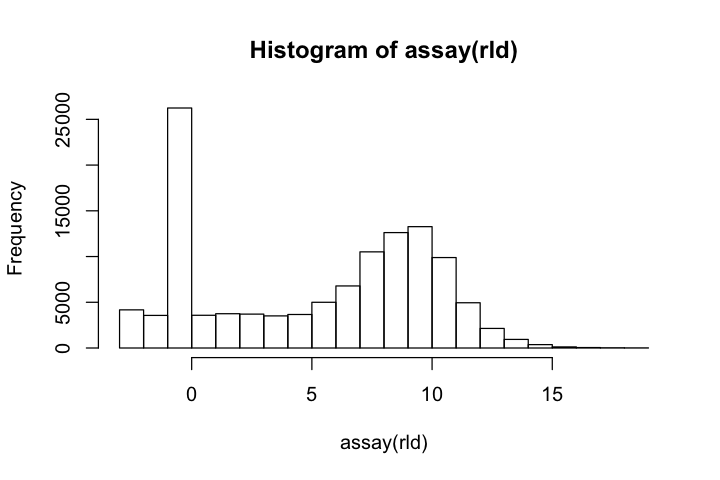

In [9]:
options(repr.plot.height=4, repr.plot.width=6)
hist(assay(rld))

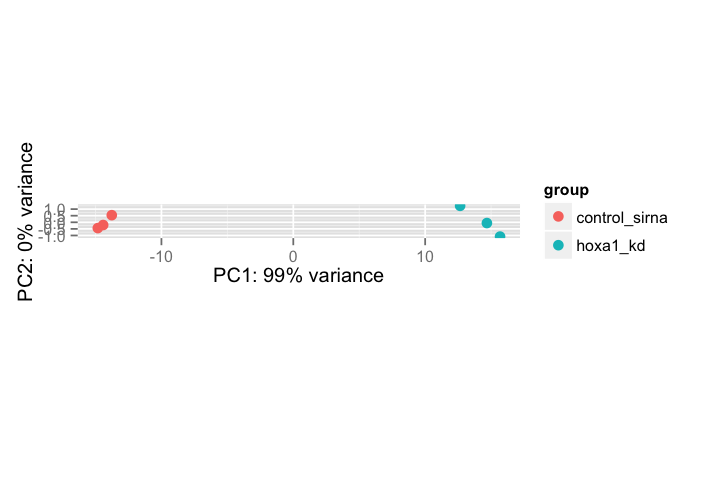

In [10]:
DESeq2::plotPCA(rld, intgroup="condition")

We see that the control/case samples are extremely well separated among the first PC.  We can also use a different routine that labels the samples:

Loading required package: genefilter

Attaching package: 'genefilter'

The following object is masked from 'package:base':

    anyNA



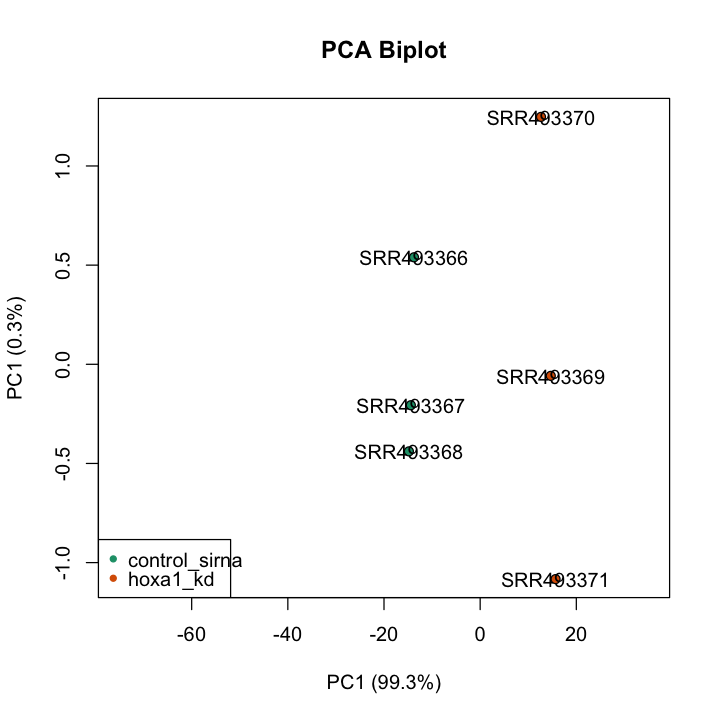

In [11]:
source('script/plot_routines.R')
library(RColorBrewer)
mycols <- brewer.pal(8, "Dark2")[1:length(unique(coldata$condition))]
options(repr.plot.height=6, repr.plot.width=6)
st_rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-75, 35))

And while sourcing the scripts are fine, unless the scripts involve just crazy amounts of code, we'd prefer to have the notebook be fairly self-contained, so that the reader can see what's going on; in that case, you copy the functions in to the notebook.

So let's spend the next 10 minutes or so making a nice notebook out of this script, adding text where you can and just using the comments where you're not sure.